In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plasma-dataset/plasma_dataset/plasma_data.csv
/kaggle/input/plasma-dataset/plasma_dataset/plasma_dataset_analysis.png


=== Plasma Anomaly Detection LSTM Training ===
Building on pre-trained CNN features
Using device: cuda

=== Loading Dataset ===
Dataset shape: (2500, 16)
Train: (1500, 13), Val: (500, 13), Test: (500, 13)

=== Extracting CNN Features ===
CNN model not found at cnn_training_output/best_plasma_cnn_model.pth. Using raw features.

=== Creating Sequence Data ===
Sequence datasets - Train: 1491, Val: 491, Test: 491

=== Initializing LSTM Model ===
LSTM Model parameters: 912,450

=== Training LSTM ===
Epoch [  1/50] Train Loss: 0.2041, Train Acc: 0.9048 | Val Loss: 0.0298, Val Acc: 0.9919, Val AUC: 0.9999
Epoch [  5/50] Train Loss: 0.0079, Train Acc: 0.9980 | Val Loss: 0.0398, Val Acc: 0.9939, Val AUC: 0.9998
Epoch [ 10/50] Train Loss: 0.0014, Train Acc: 0.9993 | Val Loss: 0.0152, Val Acc: 0.9980, Val AUC: 0.9999
Epoch [ 15/50] Train Loss: 0.0169, Train Acc: 0.9980 | Val Loss: 0.0773, Val Acc: 0.9939, Val AUC: 0.9978
Epoch [ 20/50] Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.2238, Val

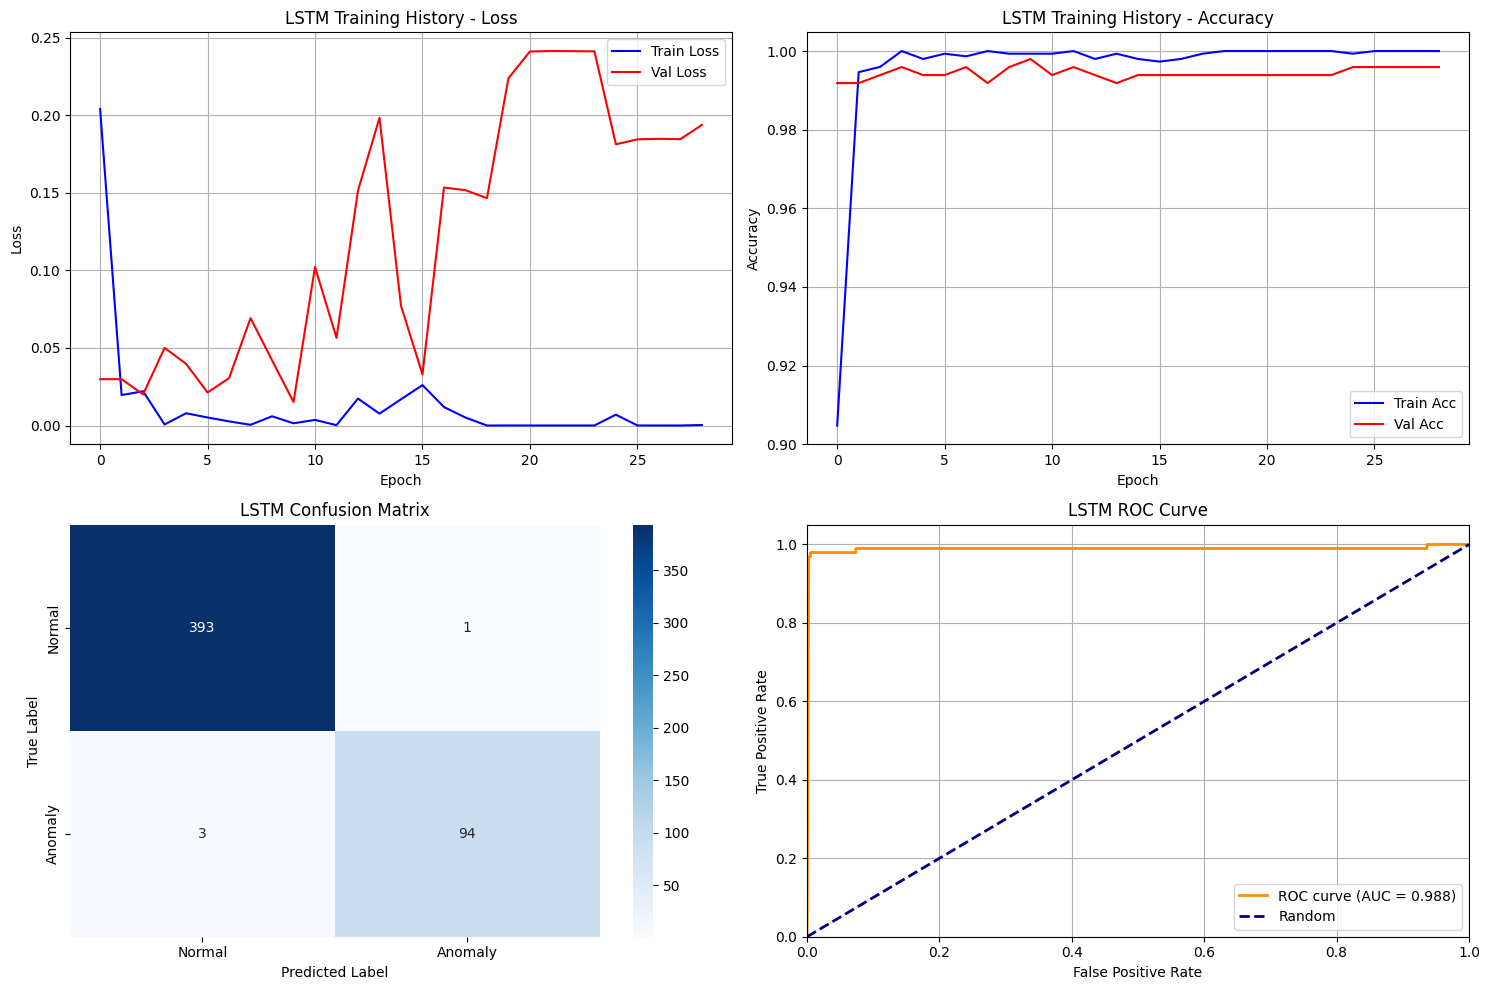


=== LSTM Training Summary ===
Best Validation AUC: 1.0000
Final Test AUC: 0.9883
Training Time: 16.7 seconds
Model saved to: lstm_training_output/best_plasma_lstm_model.pth

=== LSTM Training Complete ===
Final Test AUC: 0.9883
Ready for SNN (Neuromorphic) training phase!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
import os
import gc
import time
from typing import Tuple, Dict, List
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class PlasmaSequenceDataset(Dataset):
    """Dataset for LSTM sequence processing"""
    
    def __init__(self, sequences: np.ndarray, labels: np.ndarray, sequence_length: int = 10):
        self.sequence_length = sequence_length
        self.sequences, self.labels = self._create_sequences(sequences, labels)
        
    def _create_sequences(self, data: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Create overlapping sequences from the data"""
        sequences = []
        seq_labels = []
        
        for i in range(len(data) - self.sequence_length + 1):
            sequences.append(data[i:i + self.sequence_length])
            # Use the label of the last timestep in the sequence
            seq_labels.append(labels[i + self.sequence_length - 1])
        
        return torch.FloatTensor(np.array(sequences)), torch.LongTensor(np.array(seq_labels))
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

class PlasmaLSTM(nn.Module):
    """
    LSTM Model for Temporal Plasma Anomaly Detection
    Designed to work with CNN features as input
    """
    
    def __init__(self, input_size: int, hidden_size: int = 128, num_layers: int = 2, 
                 num_classes: int = 2, dropout_rate: float = 0.3, bidirectional: bool = True):
        super(PlasmaLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )
        
        # Calculate LSTM output size
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=lstm_output_size,
            num_heads=8,
            dropout=dropout_rate,
            batch_first=True
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(lstm_output_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        
        # Dropout and normalization
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(lstm_output_size)
        
        # Activation
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Apply layer normalization
        lstm_out = self.layer_norm(lstm_out)
        
        # Apply attention mechanism
        attended_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Use the last timestep output for classification
        last_output = attended_out[:, -1, :]
        
        # Fully connected layers
        out = self.leaky_relu(self.fc1(last_output))
        out = self.dropout(out)
        
        out = self.leaky_relu(self.fc2(out))
        out = self.dropout(out)
        
        out = self.leaky_relu(self.fc3(out))
        out = self.dropout(out)
        
        out = self.fc4(out)
        
        return out

class CNNFeatureExtractor:
    """Extract features using pre-trained CNN"""
    
    def __init__(self, cnn_model_path: str, device: torch.device):
        self.device = device
        self.cnn_model = self._load_cnn_model(cnn_model_path)
        
    def _load_cnn_model(self, model_path: str):
        """Load pre-trained CNN model"""
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Recreate the CNN model (you'll need to import the CNN class)
        from notebooks.cnn_training_t4 import PlasmaAnomalyCNN
        
        # Get input features from the checkpoint or use default
        input_features = 13  # Based on our plasma dataset
        model = PlasmaAnomalyCNN(input_features=input_features, num_classes=2)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(self.device)
        model.eval()
        
        # Remove the final classification layer to get features
        self.feature_extractor = nn.Sequential(*list(model.children())[:-1])  # Remove last FC layer
        
        return model
    
    def extract_features(self, data: np.ndarray) -> np.ndarray:
        """Extract CNN features from input data"""
        with torch.no_grad():
            data_tensor = torch.FloatTensor(data).to(self.device)
            
            # Get features from the CNN (before final classification)
            features = []
            for i in range(len(data_tensor)):
                x = data_tensor[i:i+1]
                # Forward through CNN layers except the last one
                x = x.unsqueeze(1)  # Add channel dimension for CNN
                
                # Forward through conv layers
                x = self.cnn_model.relu(self.cnn_model.bn1(self.cnn_model.conv1(x)))
                x = F.max_pool1d(x, kernel_size=2, stride=1, padding=1)
                
                x = self.cnn_model.relu(self.cnn_model.bn2(self.cnn_model.conv2(x)))
                x = F.max_pool1d(x, kernel_size=2, stride=1, padding=1)
                
                x = self.cnn_model.relu(self.cnn_model.bn3(self.cnn_model.conv3(x)))
                x = self.cnn_model.adaptive_pool(x)
                
                # Flatten
                x = x.view(x.size(0), -1)
                
                # Pass through first few FC layers for feature extraction
                x = self.cnn_model.leaky_relu(self.cnn_model.fc1(x))
                x = self.cnn_model.leaky_relu(self.cnn_model.fc2(x))
                
                features.append(x.cpu().numpy())
            
            return np.vstack(features)

def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module,
               optimizer: optim.Optimizer, device: torch.device) -> Tuple[float, float]:
    """Train LSTM for one epoch"""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (sequences, targets) in enumerate(train_loader):
        sequences, targets = sequences.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping for LSTM stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()
        
        # Memory cleanup
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    
    return epoch_loss, epoch_accuracy

def validate_epoch(model: nn.Module, val_loader: DataLoader, criterion: nn.Module,
                  device: torch.device) -> Tuple[float, float, np.ndarray, np.ndarray, np.ndarray]:
    """Validate LSTM for one epoch"""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct_predictions / total_samples
    
    return epoch_loss, epoch_accuracy, np.array(all_predictions), np.array(all_targets), np.array(all_probabilities)

def main():
    """Main LSTM training function"""
    
    print("=== Plasma Anomaly Detection LSTM Training ===")
    print("Building on pre-trained CNN features")
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load plasma dataset
    print("\n=== Loading Dataset ===")
    try:
        df = pd.read_csv('/kaggle/input/plasma-dataset/plasma_dataset/plasma_data.csv')
    except FileNotFoundError:
        try:
            df = pd.read_csv('plasma_dataset/plasma_data.csv')
        except FileNotFoundError:
            df = pd.read_csv('plasma_data.csv')
    
    print(f"Dataset shape: {df.shape}")
    
    # Prepare features and labels
    feature_columns = [col for col in df.columns if col not in ['sample_id', 'label', 'anomaly_type']]
    X = df[feature_columns].values
    y = df['label'].values
    
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")
    
    # Extract CNN features
    print("\n=== Extracting CNN Features ===")
    cnn_model_path = 'cnn_training_output/best_plasma_cnn_model.pth'
    
    if os.path.exists(cnn_model_path):
        feature_extractor = CNNFeatureExtractor(cnn_model_path, device)
        
        print("Extracting features from training data...")
        X_train_features = feature_extractor.extract_features(X_train_scaled)
        print("Extracting features from validation data...")
        X_val_features = feature_extractor.extract_features(X_val_scaled)
        print("Extracting features from test data...")
        X_test_features = feature_extractor.extract_features(X_test_scaled)
        
        print(f"CNN Features - Train: {X_train_features.shape}, Val: {X_val_features.shape}, Test: {X_test_features.shape}")
    else:
        print(f"CNN model not found at {cnn_model_path}. Using raw features.")
        X_train_features = X_train_scaled
        X_val_features = X_val_scaled
        X_test_features = X_test_scaled
    
    # Create sequence datasets
    print("\n=== Creating Sequence Data ===")
    sequence_length = 10
    
    train_dataset = PlasmaSequenceDataset(X_train_features, y_train, sequence_length)
    val_dataset = PlasmaSequenceDataset(X_val_features, y_val, sequence_length)
    test_dataset = PlasmaSequenceDataset(X_test_features, y_test, sequence_length)
    
    print(f"Sequence datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    
    # Create data loaders
    batch_size = 32  # Smaller batch for LSTM
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Initialize LSTM model
    print("\n=== Initializing LSTM Model ===")
    input_size = X_train_features.shape[1]
    model = PlasmaLSTM(
        input_size=input_size,
        hidden_size=128,
        num_layers=2,
        num_classes=2,
        dropout_rate=0.3,
        bidirectional=True
    )
    model.to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"LSTM Model parameters: {total_params:,}")
    
    # Initialize training components
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    # Training loop
    print("\n=== Training LSTM ===")
    num_epochs = 50
    best_val_auc = 0.0
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 15
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc, val_preds, val_targets, val_probs = validate_epoch(
            model, val_loader, criterion, device
        )
        
        val_auc = roc_auc_score(val_targets, val_probs)
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
        
        # Model checkpointing
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            
            # Save best LSTM model
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_auc': best_val_auc,
                'scaler': scaler,
                'sequence_length': sequence_length
            }, 'lstm_training_output/best_plasma_lstm_model.pth')
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\nEarly stopping after {epoch + 1} epochs")
            break
        
        torch.cuda.empty_cache()
    
    training_time = time.time() - start_time
    print(f"\nLSTM training completed in {training_time:.1f} seconds")
    
    # Load best model and evaluate
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Final test evaluation
    print("\n=== Final LSTM Evaluation ===")
    test_loss, test_acc, test_preds, test_targets, test_probs = validate_epoch(
        model, test_loader, criterion, device
    )
    
    test_auc = roc_auc_score(test_targets, test_probs)
    
    print(f"LSTM Test Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  AUC: {test_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(test_targets, test_preds, target_names=['Normal', 'Anomaly'], digits=4))
    
    # Create output directory
    os.makedirs('lstm_training_output', exist_ok=True)
    
    # Plot results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training history
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_title('LSTM Training History - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accuracies, label='Train Acc', color='blue')
    ax2.plot(val_accuracies, label='Val Acc', color='red')
    ax2.set_title('LSTM Training History - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Confusion matrix
    cm = confusion_matrix(test_targets, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    ax3.set_title('LSTM Confusion Matrix')
    ax3.set_ylabel('True Label')
    ax3.set_xlabel('Predicted Label')
    
    # ROC curve
    fpr, tpr, _ = roc_curve(test_targets, test_probs)
    ax4.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
    ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax4.set_xlim([0.0, 1.0])
    ax4.set_ylim([0.0, 1.05])
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.set_title('LSTM ROC Curve')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('lstm_training_output/lstm_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n=== LSTM Training Summary ===")
    print(f"Best Validation AUC: {best_val_auc:.4f}")
    print(f"Final Test AUC: {test_auc:.4f}")
    print(f"Training Time: {training_time:.1f} seconds")
    print(f"Model saved to: lstm_training_output/best_plasma_lstm_model.pth")
    
    return model, scaler, test_auc

if __name__ == "__main__":
    # Create output directory
    os.makedirs('lstm_training_output', exist_ok=True)
    
    # Run LSTM training
    model, scaler, final_auc = main()
    
    print(f"\n=== LSTM Training Complete ===")
    print(f"Final Test AUC: {final_auc:.4f}")
    print("Ready for SNN (Neuromorphic) training phase!")